In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import functools
import math
import scipy
from scipy.integrate import solve_ivp
from scipy.stats import norm

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

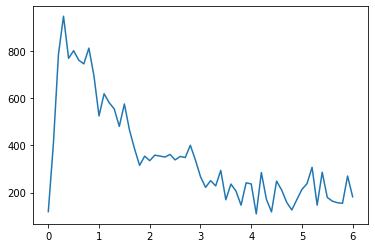

In [3]:
S0 = 900
I0 = 100
R0 = 0
x0 = [S0, I0, R0]

beta = 0.02
r = 0.6
delta = 0.15

N = 1000

t_span = np.linspace(0,6,61)

theta_vals = np.array([0.02, 0.6, 0.15])

def SIRmodel_init(t, x):
    S, I, R = x
    beta, r, delta = theta_vals
    return [delta*N-delta*S-beta*I*S, beta*I*S-(r+delta)*I, r*I - delta*R]
    
sol = scipy.integrate.solve_ivp(SIRmodel_init, [0, 6], x0, t_eval = t_span)

S=sol.y[0,:]
I=sol.y[1,:]
R=sol.y[2,:]

sigma = 50

Inoise=I
for ii in range(len(S)):
    Inoise[ii] = I[ii]+sigma*np.random.randn(1)

plt.plot(sol.t,Inoise)

In [4]:
def logmultivargaussianPDF(x,y,cov):
        logpdf = np.log(np.exp(-0.5*np.dot((x-y).T,np.dot(np.linalg.inv(cov),(x-y))))*1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov)))) 
        return logpdf

In [10]:
class DelayedRejectionAdaptiveMetropolis:

    def __init__(self, logpdf, cov, k0=1000, freq=10, sd=None, max_samples=10000, eps=1e-7):
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.k0 = k0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
       
    def sample(self, initial_sample, num_samples):
   
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
       
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
       
        accept = 0
        
        self.sample_mean = initial_sample
        for ii in range(1, num_samples):
           
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
           
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
   
            u = np.random.rand()
           
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
                self.num_samples += 1
                chollev2 = np.linalg.cholesky(0.1*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                qterm1 = logmultivargaussianPDF(y,y2,self.cov)
                qterm2 = logmultivargaussianPDF(y,self.samples[ii-1, :],self.cov)
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1)+qterm1)-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)+qterm2))
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
                    
            if ii > self.k0 and ii % self.freq:
                
                sample_mean_new = (1/(ii+1))*self.samples[ii, :] + (ii/(ii+1))*self.sample_mean
               
                update_term = self.eps*np.eye(self.dim) + ii*np.dot(self.sample_mean,self.sample_mean) - (ii+1)*np.dot(sample_mean_new,sample_mean_new) + np.dot(self.samples[ii, :],self.samples[ii, :])
                self.cov = (ii-1)*self.cov/ii + self.sd*update_term/ii
               
                self.sample_mean = sample_mean_new
                self.chol_cov = np.linalg.cholesky(self.cov)
               
            self.num_samples += 1
               
            if ii % 10 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
               
        return self.samples

In [6]:
def logpdf_SIR(theta):

    def SIRmodel(t, x):
        S, I, R = x
        N=1000
        beta, r, delta = theta
        SIRout = [delta*N-delta*S-beta*I*S, beta*I*S-(r+delta)*I, r*I - delta*R]
        return SIRout
    
    sol = scipy.integrate.solve_ivp(SIRmodel, [0, 6], [900, 100, 0], t_eval = np.linspace(0,6,61))
    
    ypdf = np.zeros(len(sol.y[1,:]))
    tpdf = np.zeros(3)
    
    if theta[0] >= 0 and theta[1] >= 0 and theta[2] >= 0:
        for ii in range(len(sol.y[1,:])):
             ypdf[ii] = np.log(norm.pdf(sol.y[1,ii],Inoise[ii], 50))
             #ypdf[ii] = np.log((1/(50*np.sqrt(2*np.pi)))*np.exp((-1/2)*np.square((Inoise[ii] - sol.y[1,ii])/50)))
            
        for jj in range(3):
             tpdf[jj] = np.log(norm.pdf(theta[jj],0,1))
        
        #print(ypdf)
        return np.sum(tpdf) + np.sum(ypdf)
    else:
        return -np.inf

In [12]:
def laplace_approx(initial_guess, logpost):
    """ Perform the laplace approximation
    
    Inputs
    -------
    initial_guess: (p, ) array of parameter guesses
    logpost: callable (p) to a scalar, denoting the posterior
    
    Output
    ------
    map_point: (p, )
    covariance: inverse hessian    
    """
    
    def neglogpost(params):
        return -logpost(params)
    
    # Gradient free method to obtain close to optimum
    res = scipy.optimize.minimize(neglogpost, initial_guess, method='Nelder-Mead')
    
    # Gradient based method to approximate hessian
    res = scipy.optimize.minimize(neglogpost, res.x)
    
    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

In [24]:
num_samples = 5000
cov_initial = np.diag(np.array([2e-4, 1e-3, 1e-3]))
theta_initial = np.array([0.02, 0.6, 0.15])
initial_sample = np.array([0.01, 0.45, 0.1])
# initial_sample = [0.1,0.1,0.1]
# mappoint, cov_initial = laplace_approx(initial_sample,logpdf_SIR)
# print(cov_initial)
# cov_initial = np.array([[3.13e-06, -1.3e-05, -3.9e-06],[-1.3e-05, 5.6e-04,1.6e-04],[-3.9e-06,1.6e-04,9.1e-05]])
# print(cov_initial)
dram = DelayedRejectionAdaptiveMetropolis(logpdf_SIR, cov_initial, freq=5, k0=300, sd=2.38**2/3, eps=1e-7, max_samples=num_samples)
samples = dram.sample(mappoint,num_samples)

/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_2147/2667890033.py:60: RuntimeWarning: invalid value encountered in log
  a2 = np.exp((y_logpdf2+np.log(1-a1y2y1)+qterm1)-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)+qterm2))


Finished sample 10, acceptance ratio = 0.25
Finished sample 20, acceptance ratio = 0.28205128205128205
Finished sample 30, acceptance ratio = 0.2033898305084746
Finished sample 40, acceptance ratio = 0.17721518987341772
Finished sample 50, acceptance ratio = 0.1414141414141414
Finished sample 60, acceptance ratio = 0.13445378151260504
Finished sample 70, acceptance ratio = 0.11510791366906475
Finished sample 80, acceptance ratio = 0.1069182389937107
Finished sample 90, acceptance ratio = 0.09497206703910614
Finished sample 100, acceptance ratio = 0.10606060606060606
Finished sample 110, acceptance ratio = 0.12037037037037036
Finished sample 120, acceptance ratio = 0.1228813559322034
Finished sample 130, acceptance ratio = 0.12109375
Finished sample 140, acceptance ratio = 0.12363636363636364
Finished sample 150, acceptance ratio = 0.1152542372881356
Finished sample 160, acceptance ratio = 0.11428571428571428
Finished sample 170, acceptance ratio = 0.11044776119402985
Finished sample 18

/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_2147/2667890033.py:54: RuntimeWarning: overflow encountered in exp
  a1y2y1 = np.exp(y_logpdf-y_logpdf2)


Finished sample 510, acceptance ratio = 0.10636182902584493
Finished sample 520, acceptance ratio = 0.10526315789473684
Finished sample 530, acceptance ratio = 0.10325047801147227
Finished sample 540, acceptance ratio = 0.10234741784037558
Finished sample 550, acceptance ratio = 0.10046082949308756
Finished sample 560, acceptance ratio = 0.10144927536231885
Finished sample 570, acceptance ratio = 0.10151380231522707
Finished sample 580, acceptance ratio = 0.09973753280839895
Finished sample 590, acceptance ratio = 0.09802235597592433
Finished sample 600, acceptance ratio = 0.09636517328825021
Finished sample 610, acceptance ratio = 0.09559434746467166
Finished sample 620, acceptance ratio = 0.09574468085106383
Finished sample 630, acceptance ratio = 0.09508460918614021
Finished sample 640, acceptance ratio = 0.09690230341540905
Finished sample 650, acceptance ratio = 0.09695074276778734
Finished sample 660, acceptance ratio = 0.09784283513097072
Finished sample 670, acceptance ratio = 

Finished sample 1880, acceptance ratio = 0.08726287262872628
Finished sample 1890, acceptance ratio = 0.08679245283018867
Finished sample 1900, acceptance ratio = 0.08632707774798927
Finished sample 1910, acceptance ratio = 0.08748999733262203
Finished sample 1920, acceptance ratio = 0.08755638100291854
Finished sample 1930, acceptance ratio = 0.08762206386909475
Finished sample 1940, acceptance ratio = 0.08771008403361344
Finished sample 1950, acceptance ratio = 0.08751306165099268
Finished sample 1960, acceptance ratio = 0.08731808731808732
Finished sample 1970, acceptance ratio = 0.0874062580811999
Finished sample 1980, acceptance ratio = 0.08828828828828829
Finished sample 1990, acceptance ratio = 0.08809218950064021
Finished sample 2000, acceptance ratio = 0.08792048929663608
Finished sample 2010, acceptance ratio = 0.08848884381338742
Finished sample 2020, acceptance ratio = 0.08829465186680122
Finished sample 2030, acceptance ratio = 0.08810240963855422
Finished sample 2040, acc

Finished sample 3250, acceptance ratio = 0.08304606706361642
Finished sample 3260, acceptance ratio = 0.0832682393376035
Finished sample 3270, acceptance ratio = 0.08348909657320873
Finished sample 3280, acceptance ratio = 0.08354037267080745
Finished sample 3290, acceptance ratio = 0.08377206565500155
Finished sample 3300, acceptance ratio = 0.08366779870330349
Finished sample 3310, acceptance ratio = 0.08356417359187442
Finished sample 3320, acceptance ratio = 0.08330776311752071
Finished sample 3330, acceptance ratio = 0.08337157717607466
Finished sample 3340, acceptance ratio = 0.08311727924355651
Finished sample 3350, acceptance ratio = 0.08286452790025847
Finished sample 3360, acceptance ratio = 0.08276489313324238
Finished sample 3370, acceptance ratio = 0.08266586066193139
Finished sample 3380, acceptance ratio = 0.08241675455778213
Finished sample 3390, acceptance ratio = 0.08231936307646087
Finished sample 3400, acceptance ratio = 0.08238466147393649
Finished sample 3410, acc

Finished sample 4610, acceptance ratio = 0.08258706467661692
Finished sample 4620, acceptance ratio = 0.08262548262548262
Finished sample 4630, acceptance ratio = 0.08279202906528679
Finished sample 4640, acceptance ratio = 0.08294880246099759
Finished sample 4650, acceptance ratio = 0.08320543740407806
Finished sample 4660, acceptance ratio = 0.08324217895427696
Finished sample 4670, acceptance ratio = 0.08317869228250191
Finished sample 4680, acceptance ratio = 0.08310641542315651
Finished sample 4690, acceptance ratio = 0.08304347826086957
Finished sample 4700, acceptance ratio = 0.08308026030368763
Finished sample 4710, acceptance ratio = 0.083008658008658
Finished sample 4720, acceptance ratio = 0.08293736501079914
Finished sample 4730, acceptance ratio = 0.08286637931034482
Finished sample 4740, acceptance ratio = 0.08268817204301075
Finished sample 4750, acceptance ratio = 0.08273419894838502
Finished sample 4760, acceptance ratio = 0.08278003855215249
Finished sample 4770, acce

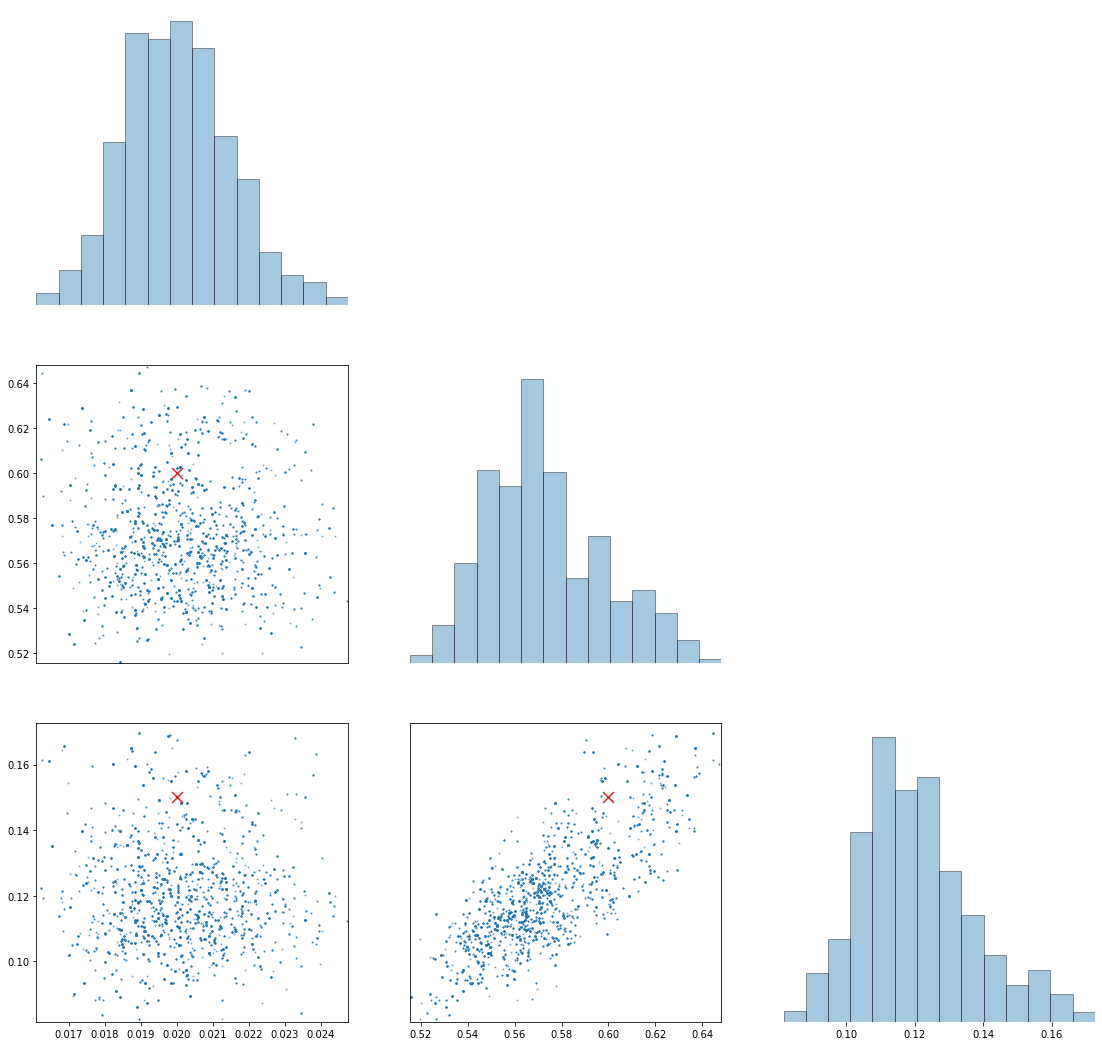

In [23]:
fig, axs, gs = scatter_matrix([samples], hist_plot=False, gamma=0.5)
axs[3].scatter(.02, .6, color='tab:red', s=120, zorder=3, marker='x')
axs[6].scatter(.02, .15, color='tab:red', s=120, zorder=3, marker='x')
axs[7].scatter(.6, .15, color='tab:red', s=120, zorder=3, marker='x')
fig.set_size_inches(15,15)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.2, hspace=0.2)


In [15]:
def autocorrelation(samples, maxlag=500, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

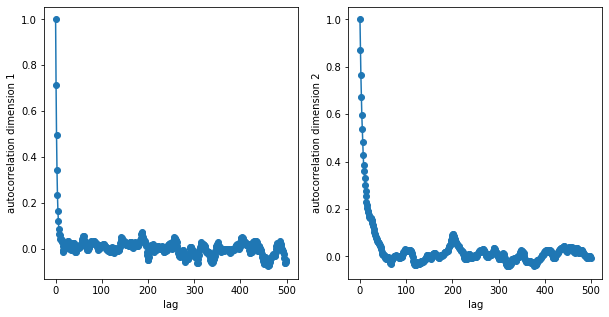

10.034758136980239
29.627267168164664
33.61969210426019


In [16]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)
IAC2 = 1+2*np.sum(autolag[:,2])
print(IAC2)

/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_2147/3372105774.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inds = np.arange(nsamples, dtype=np.int)


Text(0.5, 0, 'Sample Number')

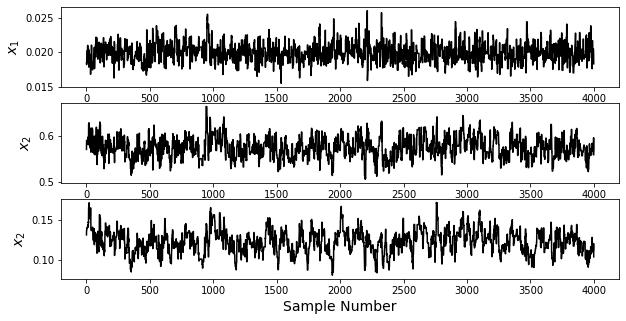

In [20]:
def sub_sample_data(samples, frac_burn=0.2, frac_use=0.7):
    """Subsample data by burning off the front fraction and using another fraction

    Inputs
    ------
    samples: (N, d) array of samples
    frac_burn: fraction < 1, percentage of samples from the front to ignore
    frac_use: percentage of samples to use after burning, uniformly spaced
    """
    nsamples = samples.shape[0]
    inds = np.arange(nsamples, dtype=np.int)
    start = int(frac_burn * nsamples)
    inds = inds[start:]
    nsamples = nsamples - start
    step = int(nsamples / (nsamples * frac_use))
    inds2 = np.arange(0, nsamples, step)
    inds = inds[inds2]
    return samples[inds, :]


samples = sub_sample_data(samples, frac_burn=0.2, frac_use=0.7)
fig, axs = plt.subplots(3,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$x_2$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

Text(0.5, 0, 'Sample Number')

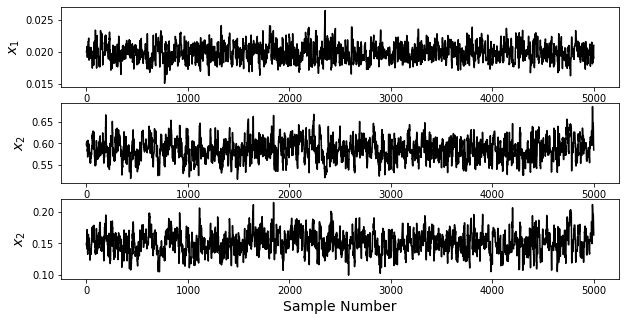

In [15]:
fig, axs = plt.subplots(3,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$x_2$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

In [17]:
def autocorrelation(samples, maxlag=100, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

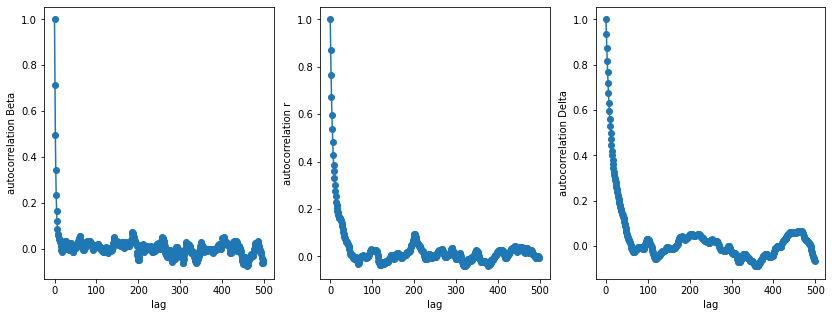

10.034758136980239
29.627267168164664
33.61969210426019


In [17]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
axs[2].plot(lags, autolag[:, 2],'-o')
axs[2].set_xlabel('lag')
axs[2].set_ylabel('autocorrelation dimension 3')
plt.show()
IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)
IAC3 = 1+2*np.sum(autolag[:,2])
print(IAC3)

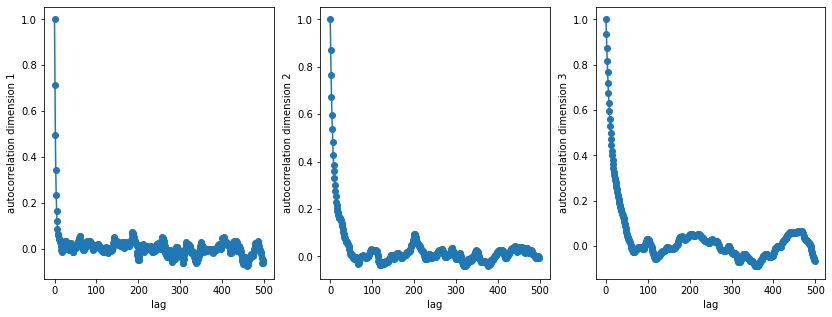

10.034758136980239
29.627267168164664
33.61969210426019


In [18]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
axs[2].plot(lags, autolag[:, 2],'-o')
axs[2].set_xlabel('lag')
axs[2].set_ylabel('autocorrelation dimension 3')
plt.show()
IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)
IAC3 = 1+2*np.sum(autolag[:,2])
print(IAC3)

In [25]:
print(np.mean(samples,0))

[0.01987426 0.58598127 0.15159749]


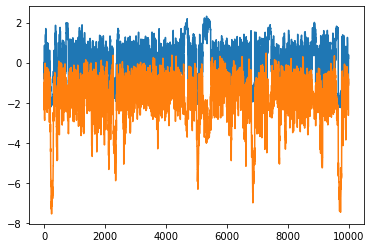

In [87]:
plt.plot(samples)

In [14]:
print(np.min(autolag))

-0.10697087739912714
